In [2]:
import csv
import pandas as pd
import re
import random
import tensorflow as tf
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt



## Import Data and convert to dataframes

In [2]:
def text_to_dataframe(filename):
    # Read the text file
    with open(filename, 'r', encoding="utf8") as file:
        lines = file.readlines()

    # Split each line by tab and create a list of lists
    data = [line.strip().split('\n') for line in lines]
    df = pd.DataFrame(data)
    return df

In [3]:
#initialize filepaths
en_training_file = 'train.txt'  
de_training_file = 'train.de.txt'

#create dataframe representations 
en_training = text_to_dataframe(en_training_file)
de_training = text_to_dataframe(de_training_file)

In [4]:
#check length 
print("English dataset :",len(en_training),", German dataset:",len(de_training))

English dataset : 4468798 , German dataset: 4468798


## clearing empty rows in the dataframe

In [5]:
en_training = en_training.dropna()
de_training = de_training.dropna()

In [6]:
en_training = en_training[~(en_training == '').all(axis=1)]
de_training = de_training[~(de_training == '').all(axis=1)]


In [7]:
print("English dataset :",len(en_training),", German dataset:",len(de_training))

English dataset : 4468798 , German dataset: 4468798


## View cleaned dataframe

In [8]:
en_training=en_training.reset_index().drop("index",axis=1)
de_training=de_training.reset_index().drop("index",axis=1)

data = pd.DataFrame()
data["en"]=en_training
data["de"]=de_training

In [9]:
data.iloc[30,:3]

en    Now , things are made much easier with the arr...
de    Mit QuarkXPress 8 ist das jetzt viel einfacher...
Name: 30, dtype: object

# I. Preprocess - Cleaning and tokenizing data

#### Making and testing cleaning functions

In [10]:
#we use 2 diff cleaning functions, one for each language
def clean_en(word):
    
    #removes words in between hashtags
    word = re.sub(r'##AT##', ' ', word)
    
    # Remove non-English/non-German letters, punctuation (except '), numbers, and other characters
    word = re.sub(r'<.*?>|\(.*?\)', '', word)
    word = re.sub(r'[^a-zA-ZÄÖÜäöüß)(\s]', '', word)
    
    #removes html tags
    #word = re.sub(r"[^a-zA-Z'’<>]+|<[^a-z>]+>", ' ', word)
    
    # Remove repeating letters more than 5 times
    word = re.sub(r"(.)\1{4,}", r"\1\1\1\1\1", word)

    word = word.lower()
    return word

def clean_de(sentence):
    german_nouns = set(['der', 'die', 'das', 'den', 'dem', 'des', 'ein', 'eine', 'einen', 'einem', 'eines'])

    def capitalize_word(sentence, index):
        word = sentence[index]
        if index == 0:
            return word.lower()
        if sentence[index-1] in german_nouns:
            return word
        else:
            return word.lower()

    words = sentence.split()
    capitalized_words=[]
    for i, word in enumerate(words):
        word = capitalize_word(words, i)
        word = re.sub(r'##at##', '', word)
        word = re.sub(r'[^a-zA-ZÄÖÜäöüß\-)(\s]', '', word)
        word = re.sub(r'<.*?>|\(.*?\)', '', word)
        word = re.sub(r'\(.*?\)', '', word)        
        
        capitalized_words.append(word)
        capitalized_sentence = ' '.join(capitalized_words)
        
    return capitalized_sentence


#### Subsample data

In [11]:
data=data.sample(40000)

,en,de
1737603,Since the second milestone of GWT has been rel...,Ich habe gerade zusammen mit meiner Tochter lo...
745415,The lady in the reception was very corporative .,"Freundlicher Empfang , Zimmer funktional und s..."
2331226,For the second time managers of Siltronic exch...,Bei dem Treffen standen die Kommunikation und ...
2335816,"Some action cards must be used immediately , o...",Manche Aktionskarten müssen sofort ausgespielt...
1847958,The company was born as an answer to the needs...,Das Unternehmen entsteht als Antwort auf das B...
...,...,...
1044797,This was our second stay at the Hotel this yea...,Wir werden uns sicher bald wiedersehen . Liebe...
863612,It &apos;s also possible to shoot such common ...,"Auch kann man hier auf den Fuchs , Wolf , Hase..."
1168971,"In addition , the pre ##AT##-##AT## operating ...",Darüber hinaus belasteten die Vorlaufkosten de...
2620452,There is a freedom and a freshness in this whi...,"Das offenbart eine Freiheit und eine Frische ,..."


#### clean and tokenize

In [1]:
#overwrite dataset with cleaned and tokenized sentence
data["en"]=[clean_en(i).split() for i in data["en"]]
data["de"]=[clean_de(i).split() for i in data["de"]]
data.head()

NameError: name 'data' is not defined

#### printing data summary after tokenizing n cleaning

In [13]:
print("Dataset length : \n English dataset : ",len(data["en"]),",\n German dataset:",len(data["de"]))
import statistics as stat
en=[len(i)for i in data["en"]]
de=[len(i)for i in data["de"]]
n=50
en_max=0
de_max=0
for i in range(len(en)):
    if en[i]>n:
        en_max+=1
    if de[i]>n:
        de_max+=1
en_vocab = max(en)
de_vocab = max(de)

print("Max sentence length,\n in English : {} \n in German: {}".format(max(en),max(de)))
print("Mean sentence length,\n in English : {} \n in German: {}".format(stat.mean(en),stat.mean(de)))
print(f"Num of sentences with more than {n} sentences\n in English : {en_max}\n in German : {de_max}") 

Dataset length : 
 English dataset :  40000 ,
 German dataset: 40000
Max sentence length,
 in English : 92 
 in German: 90
Mean sentence length,
 in English : 22.49035 
 in German: 21.4417
Num of sentences with more than 50 sentences
 in English : 1515
 in German : 1200


In [14]:
#reset index after cleaning
data.reset_index(drop=True,inplace=True)

# II. Preprocess - remove long sentences

In [15]:
# remove sentences above 50 words in english
def remove_max_length(l,en,de):
    idx = []
    for index,length in enumerate(en):
        if en[index]>l:
            idx.append(index)
            print(index)
            pass
        if de[index]>l:
            print(index)
            idx.append(index)
    return idx     

In [16]:
#removes all occurences of sentences that are above 50 words(in the english language)
idx=remove_max_length(50,en,de)
data.drop(idx,inplace=True)

11
11
115
115
132
133
156
197
232
232
235
241
251
251
273
273
289
296
331
331
336
363
373
381
394
409
409
420
420
434
475
475
481
535
551
557
565
565
573
573
592
597
605
605
610
610
612
612
643
669
669
681
681
687
687
695
775
775
787
795
795
810
810
824
824
846
846
871
871
872
872
878
878
885
912
912
915
1019
1048
1063
1133
1133
1143
1157
1158
1199
1199
1214
1215
1222
1254
1254
1282
1282
1308
1308
1326
1328
1328
1339
1368
1368
1408
1409
1410
1432
1473
1482
1482
1512
1518
1521
1521
1527
1527
1539
1539
1613
1613
1633
1641
1651
1666
1666
1667
1672
1672
1677
1677
1696
1716
1716
1754
1791
1791
1845
1869
1869
1872
1919
1919
1938
1938
1964
1967
1982
1983
1983
2012
2024
2036
2036
2048
2048
2050
2050
2055
2059
2129
2152
2152
2188
2200
2209
2209
2311
2317
2349
2389
2389
2444
2445
2445
2540
2553
2553
2556
2556
2616
2616
2626
2626
2629
2661
2661
2689
2703
2720
2720
2767
2767
2803
2824
2824
2871
2918
2971
2975
2989
2989
3008
3008
3019
3053
3053
3080
3110
3110
3133
3138
3151
3151
3239
3239
3262
3298

21860
21898
21898
21911
21917
21926
21926
21934
21949
21950
21950
21952
21952
21978
21979
21979
21983
22049
22049
22088
22152
22190
22197
22198
22198
22208
22236
22299
22303
22328
22330
22355
22355
22363
22367
22378
22378
22410
22410
22466
22466
22529
22529
22537
22549
22549
22559
22566
22572
22572
22589
22610
22645
22646
22646
22694
22699
22702
22711
22711
22718
22762
22769
22777
22777
22818
22843
22857
22857
22884
22929
22930
22952
22960
22990
23005
23017
23020
23020
23064
23068
23068
23124
23186
23202
23202
23207
23207
23219
23221
23221
23241
23297
23298
23298
23314
23347
23354
23377
23434
23434
23449
23449
23463
23494
23494
23507
23520
23520
23527
23536
23589
23589
23626
23626
23671
23671
23672
23699
23764
23768
23826
23843
23851
23851
23856
23856
23869
23869
23877
23912
23930
23931
23977
23978
23978
24033
24068
24098
24098
24108
24127
24127
24161
24170
24185
24196
24196
24205
24206
24219
24221
24236
24237
24247
24249
24254
24335
24335
24360
24373
24373
24381
24381
24398
24438
2444

In [17]:
#reset index of dataframe
data.reset_index(drop=True,inplace=True)

#### print data summary after cutoff

In [18]:
print("Dataset length : \n English dataset : ",len(data["en"]),",\n German dataset:",len(data["de"]))
import statistics as stat
en=[len(i)for i in data["en"]]
de=[len(i)for i in data["de"]]
n=50
en_max=0
de_max=0
for i in range(len(en)):
    if en[i]>n:
        en_max+=1
    if de[i]>n:
        de_max+=1
print("Max sentence length,\n in English : {} \n in German: {}".format(max(en),max(de)))
print("Mean sentence length,\n in English : {} \n in German: {}".format(stat.mean(en),stat.mean(de)))
print(f"Num of sentences with more than {n} sentences\n in English : {en_max}\n in German : {de_max}") 

Dataset length : 
 English dataset :  38064 ,
 German dataset: 38064
Max sentence length,
 in English : 50 
 in German: 50
Mean sentence length,
 in English : 20.852222572509458 
 in German: 19.926465952080708
Num of sentences with more than 50 sentences
 in English : 0
 in German : 0


In [19]:
#Function to look at random subset of data 
def random_select(data,num_items):
    # Randomly select a subset of items
    random_subset = random.sample(range(len(data)), num_items)
    for i in random_subset:
        
        print(" EN[",i+1,"] : ", data["en"][i+1],"\n")
        print(" DE[",i+1,"] : ", data["de"][i+1],"\n")
        print("===============================")

    return 
random_select(data,1)

 EN[ 14888 ] :  ['do', 'you', 'like', 'best', 'western', 'university', 'inn'] 

 DE[ 14888 ] :  ['magst', 'du', 'best', 'western', 'university', 'inn'] 



# III.  Building Corpus

In [20]:
#initialize train,test variables
X_train=data["en"]
y_train=data["de"]

#### append End of Speech tags

In [21]:
for index,i in enumerate(X_train):
    X_train[index].append("<EOS>")

In [22]:
for index,i in enumerate(y_train):
    y_train[index].append("<EOS>")

In [23]:
def Build_corpus(data,Corpus):
    """"Corpus is a dictionary of all the individual words in all documents (entire X_train),
        where Key = word, value = (index,count).
        Corpus initalisation should be a dictionary (empty or not)
    """
    index = 1
    for sentence in data:
        for word in sentence:
            if word in Corpus.keys():
                count = Corpus[word][1]+1
                idx = Corpus[word][0]
                Corpus[word] = [idx,count]
            else:
                count = 1
                Corpus[word] = [index,count]
                index += 1
                    
                    
    print("Built Corpus")
    return Corpus   

#### build corpus for each language

In [24]:
Corpus_en= Build_corpus(X_train,Corpus={})
Corpus_de = Build_corpus(y_train,Corpus={})

Built Corpus
Built Corpus


In [25]:
print(f"length of english corpus : {len(Corpus_en)}, length of dutch corpus : {len(Corpus_de)}")

length of english corpus : 41893, length of dutch corpus : 88287


In [26]:
#view corpus examples
Corpus_en["iron"]

[6732, 22]

#### Use index from corpus to encode words in training data 

In [27]:
def encode(data,Corpus):
    df=pd.DataFrame()
    all_sentence=[]
    for sentence in data:
        encoded_sen=[]
        for word in sentence: 
            if word=="<end>":
                pass
            if word in Corpus.keys(): 
                index = Corpus[word][0]
                encoded_sen.append(index)
            else:
                print(f"{word} not in corpus")
        all_sentence.append(encoded_sen)
    print("Finished encoded data")
    return all_sentence
              

In [28]:
X_train=encode(X_train,Corpus_en)
y_train=encode(y_train,Corpus_de)


Finished encoded data
Finished encoded data


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 5,
 2,
 20,
 21,
 22,
 2,
 20,
 23,
 24,
 25]

#### Save encoded xtrain and y_train 

In [29]:
# Save dictionary
with open("Corpus_en.pickle", "wb") as file:
    pickle.dump(Corpus_en, file)

with open("Corpus_de.pickle", "wb") as file:
    pickle.dump(Corpus_de, file)

# # Load dictionary
# with open("Corpus_de.pickle", "rb") as file:
#     Corpus_de = pickle.load(file)

# with open("Corpus_en.pickle", "rb") as file:
#     Corpus_en = pickle.load(file)

# IV. Seq-Seq encoder-decoder Model

In [30]:
#import
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding
from tensorflow.keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

#### define key variables for model


In [31]:
max_features = len(Corpus_en) #max number of unique words or tokens in your dataset
max_len = 51  # Maximum length of input sequences
batch_size = 100
embedding_dims = 3  # Dimensionality of the word embeddings
epochs = 200
en_length = len(Corpus_en)
de_length = len(Corpus_de)

#### Check length

In [4]:
print('X_train shape:', len(X_train),",with max sentence length:",max([len(i) for i in X_train]))

print('y_train shape:', len(y_train),",with max sentence length:",max([len(i) for i in y_train]))


NameError: name 'X_train' is not defined

#### padding sequence with zeros to a uniform length

In [34]:
#padding the ends of the sentence
X_train_pad = pad_sequences(X_train, maxlen = max_len, padding = "post")

In [35]:
y_train_pad = pad_sequences(y_train, maxlen = max_len, padding = "post")


#### Model Definition


In [49]:
physical_devices = tf.config.list_physical_devices('RAM')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:

def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, 128, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units,return_sequences=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units,return_sequences=True))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [53]:
# initialize model with existing corpus lengths 
model = define_model(len(Corpus_en)+1, len(Corpus_de)+1, 51, 51, 64)

### Compile model

In [56]:
# uses adam optimizer with learning rate = 0.01 
model.compile(optimizer=Adam(0.01), loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

#### Train Model

In [57]:
history = model.fit(X_train_pad, y_train_pad,
                    epochs=30, batch_size=100, validation_split = 0.2,
                    verbose=1)

Epoch 1/30
305/305 [==============================] - 3065s 10s/step - loss: 4.1636 - accuracy: 0.5867 - val_loss: 3.8226 - val_accuracy: 0.5856
Epoch 2/30
305/305 [==============================] - 2079s 7s/step - loss: 3.6260 - accuracy: 0.5936 - val_loss: 3.7144 - val_accuracy: 0.5927
Epoch 3/30
305/305 [==============================] - 2057s 7s/step - loss: 3.5327 - accuracy: 0.5979 - val_loss: 3.7040 - val_accuracy: 0.5920
Epoch 4/30
305/305 [==============================] - 2047s 7s/step - loss: 3.4708 - accuracy: 0.5989 - val_loss: 3.7332 - val_accuracy: 0.5924
Epoch 5/30
305/305 [==============================] - 2050s 7s/step - loss: 3.4061 - accuracy: 0.6001 - val_loss: 3.6724 - val_accuracy: 0.5916
Epoch 6/30
305/305 [==============================] - 2067s 7s/step - loss: 3.3525 - accuracy: 0.6012 - val_loss: 3.7001 - val_accuracy: 0.5852
Epoch 7/30
305/305 [==============================] - 2063s 7s/step - loss: 3.3085 - accuracy: 0.6023 - val_loss: 3.6949 - val_accuracy

###  Plot training results

In [74]:
def save_history(model,hist,model_name):
    # Save the model
    with open(model_name+'.pkl', 'wb') as file:
        pickle.dump(model, file)

    # Save the training history
    with open(model_name+'_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)
    print(f"{model_name}'s history saved ")
import matplotlib.pyplot as plt

from tensorflow import keras

def save_model(model, model_name):
    # Save the model
    model.save(model_name + '.h5')
    print("Model saved as", model_name + '.h5')


def plot_training_metrics(history, model_name):
    
    
    # Plotting the training loss
    plt.plot(history.history['loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(model_name+'history.png')

    plt.show()

    # Plotting the training accuracy
    plt.plot(history.history['accuracy'])
    plt.title(f'Training Accuracy of {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig(model_name+'Acc.png')
    plt.show()
def load_model(filename):
    #filename should be in ".h5" format
    

    # Load the model with custom objects
    model = keras.models.load_model(filename, custom_objects={'LSTMCell': keras.layers.recurrent.LSTMCell})
    return model

INFO:tensorflow:Assets written to: ram://bde188b6-1a2c-4c23-89fa-1c8c40d15f62/assets


INFO:tensorflow:Assets written to: ram://bde188b6-1a2c-4c23-89fa-1c8c40d15f62/assets


seq2seq_keras's history saved 
Model saved as seq2seq_keras.h5


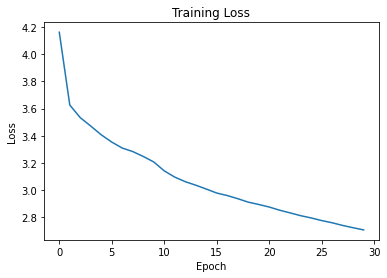

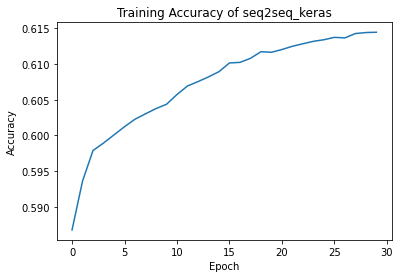

In [75]:
m_name="seq2seq_keras"
save_history(model,history,m_name)
save_model(model,m_name)
plot_training_metrics(history,m_name)
